<!--# GPinfo: Scaling up the Bayesian GPLVM with informative prior-->
# Applying GPinfo to the *Arabidopis thaliana* microarray data
_Sumon Ahmed_, 2017

<!--The sparse variational inference of the Bayesian GPLVM allows the computation of an exact lower bound of the marginal log likelihood $\log p(Y|\theta)$ by variationaly integrating out the input/latent variables of the GP. 
-->
This notebooks depicts how GPinfo with informative prior over the latent space can be used to infer one dimensional pseudotime from microarray data.   

In [3]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix
from utils import plot, plot_comparison, calcroughness
%matplotlib inline

## Data decription
<a href="https://www.ncbi.nlm.nih.gov/pubmed/23023172" terget="_blank">Windram et al. (2012)</a> analysed the effects of Botrytis cinera infection on *Arabidopis
thaliana*. The generated time series contained 24 distinct capture time points for both infected and control conditions. 

The WindramTrainingData.csv contains the expression profiles of the 100 genes of the 24 cells in infected conditions which have been used in the inference.

The WindramMetaData.csv contains the additional information of the data such as capture time of each cells, different initializations of latent space, etc.

In [4]:
Y = pd.read_csv('data/Windram/WindramTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('data/Windram/WindramMetaData.csv', index_col=[0])

In [5]:
N, D = Y.shape

In [6]:
mData.head()

,cell,obstime,condition,capture,obstime.orig,capture.orig,init_1,init_2,init_3,init_4,...,init_11,init_12,init_13,init_14,init_15,init_16,init_17,init_18,init_19,init_20
1,GSM734540,6,Botrytis,6,2,2,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,8.478261,8.478261
2,GSM734541,6,Botrytis,6,4,4,4.826087,4.826087,4.826087,4.826087,...,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,12.130435,12.130435
3,GSM734542,6,Botrytis,6,6,6,8.478261,6.652174,6.652174,6.652174,...,6.652174,6.652174,6.652174,6.652174,6.652174,6.652174,6.652174,6.652174,3.000000,10.304348
4,GSM734543,6,Botrytis,6,8,8,6.652174,10.304348,10.304348,8.478261,...,8.478261,10.304348,10.304348,10.304348,8.478261,8.478261,8.478261,10.304348,6.652174,6.652174
5,GSM734544,6,Botrytis,6,10,10,10.304348,8.478261,8.478261,10.304348,...,10.304348,8.478261,8.478261,8.478261,10.304348,10.304348,10.304348,8.478261,13.956522,3.000000


## Model Construction
The first step of using the GPinfo is to initialize the model with the observed data and the additional metadata (optional).

In [7]:
mp = GrandPrix(Y, mData)

### Build sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mappring mapping from the latent space to the data space in Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

In [8]:
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values[:, None]

X_mean = [prior_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)]   

priors = {'Priormean':prior_mean, 'Priorvar':np.square(sigma_t)}
vParams = {'Xmean':np.asarray(X_mean)}

mp.build_model(priors, vParams, kernel={'name':'Matern32', 'ls':18.0, 'var':1.0})

### Run the model
- `fit_model` optimizes the model.
- `get_pseudotime` returns the estimated pseudotime points.

In [9]:
mp.fit_model()

In [10]:
pseudotimes = mp.get_pseudotime()

## Visualize the results
Estimated pseudotimes have been plotted against the actual cell capture times to visualize the correspondence between them. Each point represents a particular cell.

The points are coloured according to the actual cell capture time. 

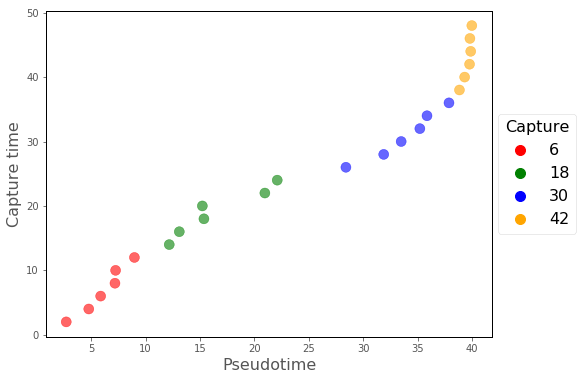

In [11]:
actual_capture_time = mData['capture.orig'].values
plot('', 'Pseudotime', 'Capture time', pseudotimes, actual_capture_time, mData['capture'].values)

## Comparison to the <a href="https://github.com/JohnReid/DeLorean" target="_blank" style="text-decoration:none;"> DeLorean Model</a>
* $20$ different initializations have been used
* Models have been compared for varying number of inducing points in terms of -
> * the rank correaltions between actual capture time and estimated pseudotimes
> * the fitting times required 

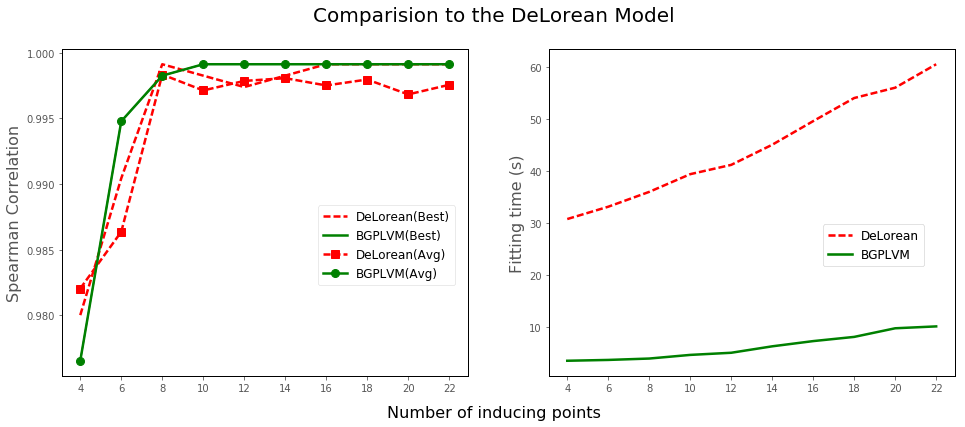

In [12]:
plotDf = pd.read_csv('data/Windram/WindramDeLorean.csv', index_col=[0])
plot_comparison(plotDf)

## Roughness
Roughness for a particular gene is defined in <a href="https://www.ncbi.nlm.nih.gov/pubmed/27318198" target="_blank">DeLorean</a> as 
$$\frac{1}{\sigma_g} \sqrt{ \frac{1}{C-1} 
\sum_{c=1}^{C-1} \left(x_{g, z_c} - x_{g, z_{c+1}} \right)^2 }$$
where
* $\sigma_g$ the standard deviation of gene expression
* $x_{g, z_c}$ is the gene expression for gene $g$ at pseudotime order $z_c$

This metric measures the smoothness of the gene expression profile by looking at the differences of consecutive measurements. Smaller values indicate a smoother response.

The average roughness statistics for 50 heldout genes using different number of inducing points have been noted. The green bars are proportional to the values shown. 

In [13]:
plotDf[['inducingPoints','GPLVM_avg_roughness']].style.bar(color='lightgreen')

### The following code will regenerate the comparison and roughness results 
- The code uses 20 different initial conditions from WindramMetaData.csv file.
- 50 heldout genes have been loaded from the WindramHeldOut.csv file.

Runnig the following code may take upto 25 mins.

In [14]:
from scipy.stats import spearmanr

heldOut = pd.read_csv('data/Windram/WindramHeldOut.csv', index_col=0) # G X N

u = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
keys = mData.keys()
rows = len(u)
cols = len(keys) - 6
actualCaptureTime = mData['capture.orig'].values
reqTime = np.zeros((rows, cols))
spearCorr = np.zeros((rows, cols))
roughness = np.zeros((rows, cols))

for i in range(0, rows):
    for j in range(0, cols):
        vParams = {'Xmean':keys[j + 6]}
        mp.build_model(priors, vParams, kernel={'name':'Matern32', 'ls':18.0, 'var':1.0}, n_inducing_points = u[i])
        mp.fit_model()
        pseudotimes = mp.get_pseudotime()
        spearCorr[i,j] = spearmanr(pseudotimes, actualCaptureTime)[0]
        reqTime[i,j] = mp.get_model_fitting_time()
        roughness[i,j] = np.mean(calcroughness(heldOut.values, pseudotimes.reshape(-1)))
        
bestSpearCorr = np.zeros(rows)
avgSpearCorr = np.zeros(rows)
avgReqTime = np.zeros(rows)
avgRoughness = np.zeros(rows)
for n in range(0,rows):
    bestSpearCorr[n] = np.max(spearCorr[n])
    avgSpearCorr[n] = np.mean(spearCorr[n])
    avgReqTime[n] = np.mean(reqTime[n])
    avgRoughness[n] = np.mean(roughness[n])

plotDf['GPLVM_avg'] = avgSpearCorr
plotDf['GPLVM_best'] = bestSpearCorr
plotDf['GPLVM_fitting_time'] = avgReqTime
plotDf['GPLVM_avg_roughness'] = avgRoughness

In [17]:
plot_comparison(plotDf)

In [18]:
plotDf[['inducingPoints','GPLVM_avg_roughness']].style.bar(color='lightgreen')